In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline 

from matplotlib.pyplot import figure
figure(figsize=(20,20), dpi=200)

import IPython
import IPython.display

from pylab import rcParams
rcParams["figure.figsize"] = 20,20

#from plotly import __version__
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

<Figure size 4000x4000 with 0 Axes>

In [2]:
cwd = os.getcwd()
data_base_path = os.path.join(cwd, "orlen_stock_v2.db")

In [3]:
def connect_db(path):
    db = sqlite3.connect(path)
    return db

con = connect_db(data_base_path)
df = pd.read_sql_query("SELECT * from pkn_stock_v2 ORDER by date ASC", con)

print(df.head())
con.close()

                  date  open    MIN   MAX  close     volume       trade
0  2000-02-02 00:00:00  24.9  25.10  24.6   25.0  1119386.0  55633484.0
1  2000-02-03 00:00:00  25.2  26.11  25.2   25.9  1286766.0  66023963.0
2  2000-02-04 00:00:00  26.2  26.50  25.4   25.6   990461.0  51404926.0
3  2000-02-07 00:00:00  25.5  25.70  25.1   25.3   855721.0  43470627.0
4  2000-02-08 00:00:00  25.3  25.30  24.8   25.0  1232197.0  61733070.0


In [4]:
df = df.set_index("date")
df.head()

,open,MIN,MAX,close,volume,trade
date,,,,,,
2000-02-02 00:00:00,24.9,25.10,24.6,25.0,1119386.0,55633484.0
2000-02-03 00:00:00,25.2,26.11,25.2,25.9,1286766.0,66023963.0
2000-02-04 00:00:00,26.2,26.50,25.4,25.6,990461.0,51404926.0
2000-02-07 00:00:00,25.5,25.70,25.1,25.3,855721.0,43470627.0
2000-02-08 00:00:00,25.3,25.30,24.8,25.0,1232197.0,61733070.0


In [5]:
df.tail()

,open,MIN,MAX,close,volume,trade
date,,,,,,
2021-06-21 00:00:00,78.32,79.46,76.58,79.08,853056.0,66738700.0
2021-06-22 00:00:00,80.26,80.78,79.20,79.48,847395.0,67595456.0
2021-06-23 00:00:00,79.94,80.20,79.54,79.70,484639.0,38674708.0
2021-06-24 00:00:00,79.98,80.10,78.94,79.84,866538.0,68937296.0
2021-06-25 00:00:00,79.98,80.40,79.02,79.38,637682.0,50739344.0


In [6]:
import tensorflow as tf
import numpy as np

class WindowGenerator():
    def __init__(self, sequnce_lengh, n_future, shift,
                train_df, test_df=None, val_df=None,
                label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}
        # Work out the window parameters.
        self.sequnce_lengh = sequnce_lengh
        self.n_future= n_future
        self.shift = shift # skip how many Y data forward (shift 2 means every third label is used)

        self.total_window_size = sequnce_lengh + shift

        self.input_slice = slice(0, sequnce_lengh)
        
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.n_future
        
        self.labels_slice = slice(self.label_start, None)
        
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            if not isinstance(self.label_columns, list):
                raise TypeError(f"label_columnsattribute must be set to an instance of {list}")
            """labels = tf.stack(
                [labels[:, :, 2]] ,
                axis=-1)
            
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)"""
            self.labels_slices=[]
            for name in self.label_columns:
                self.slices = labels[:,:,self.column_indices[str(name)]]
                self.labels_slices.append(self.slices)
            labels = tf.stack(self.labels_slices, axis=-1)
                
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.sequnce_lengh, None])
        labels.set_shape([None, self.n_future, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=64,)

        ds = ds.map(self.split_window)
        return ds
    
    def plot(self, model=None, plot_col="close", max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Date')

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [7]:
def rsi(df, periods=14, ema=True):
    """
    Retruns Relative strengh index value
    """
    close_delta = df["close"].diff(1).dropna()
    # make 2 series - up and down
    up = close_delta.clip(lower=0)
    down = -1*close_delta.clip(upper=0)
    if ema == True:
        ma_up = up.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
        ma_down = down.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    else:
        #use simple moving avg
        ma_up = up.rolling(window=periods).mean()
        ma_down = down.rolling(window=periods).mean()
        
    rsi = ma_up/ma_down
    rsi = 100 - (100/(1+rsi))
    
    return rsi

def EMA(df, period=20, column="close"):
    return df[column].ewm(span=period, adjust=False).mean()

def MACD(df, period_long=26, period_short=12, period_signal=9, column="close"):
    short_ema = EMA(df, period_short, column=column)   
    long_ema = EMA(df, period_long, column=column)
    df["MACD"] = short_ema-long_ema
    df["SIGNAL_Line"] = EMA(df, period_signal, column="MACD")
    return df

def profits(df, column_open="open", column_close="close"):
    df["profit"] = df[column_close]-df[column_open]
    df["% profit"] = df["profit"]*100/df[column_open]
    return df
 
def ATR(df, look_back=14 ,min_column="MIN", max_column="MAX", close_column="close"):
    high_low = df[max_column] - df[min_column]
    high_close = np.abs(df[max_column] - df[close_column].shift())
    low_close = np.abs(df[min_column] - df[close_column].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df["ATR"] = true_range.rolling(look_back).sum()/look_back
    return df


def get_adx(df, look_back, min_column="MIN", max_column="MAX", close_column="close"):
    plus = df[max_column].diff().clip(lower=0)
    minus = df[min_column].diff().clip(upper=0)
    tr1 = pd.DataFrame(df[max_column]-df[min_column])
    tr2 = pd.DataFrame(abs(df[max_column]-df[close_column].shift(1)))
    tr3 = pd.DataFrame(abs(df[min_column]-df[close_column].shift(1)))
    frames=[tr1, tr2, tr3]
    join_tr = pd.concat(frames, axis=1, join="inner").max(axis=1)
    atr = join_tr.rolling(look_back).mean()
    
    plus_di = 100*(plus.ewm(alpha=1/look_back).mean()/atr)
    minus_di = abs(100*(minus.ewm(alpha=1/look_back).mean()/atr))
    dx = (abs(plus_di-minus_di)/abs(plus_di+minus_di))*100
    adx=((dx.shift(1)*(look_back-1))+dx)/look_back
    adx_smooth = adx.ewm(alpha=1/look_back).mean()
    
    df["plus_di"], df["minus_di"], df["adx_smooth"] = plus_di, minus_di, adx_smooth
    
    return df

In [8]:
rolling_means = [5,10,20,100]
for i in rolling_means:
    df.loc[:, "ma"+str(i)] = df.close.rolling(i).mean()

df = ATR(df)
df = get_adx(df, look_back=14)
df = profits(df)
df = MACD(df)
df["rsi"] = rsi(df)
df = df.dropna()

In [9]:
df.head()

,open,MIN,MAX,close,volume,trade,ma5,ma10,ma20,ma100,ATR,plus_di,minus_di,adx_smooth,profit,% profit,MACD,SIGNAL_Line,rsi
date,,,,,,,,,,,,,,,,,,,
2000-06-28 00:00:00,21.3,21.3,21.00,21.10,409181.0,17308356.0,21.460,21.710,21.6200,22.6563,0.400000,22.812376,38.453767,18.928901,-0.20,-0.938967,-0.078375,-0.033901,43.290099
2000-06-29 00:00:00,21.2,21.6,21.00,21.10,1273651.0,54257533.0,21.320,21.590,21.6350,22.6173,0.414286,20.451523,34.474187,19.401173,-0.10,-0.471698,-0.108005,-0.048722,43.290099
2000-06-30 00:00:00,21.0,21.3,20.60,20.69,829135.0,34740757.0,21.078,21.449,21.6145,22.5652,0.435714,18.055951,35.356877,19.874664,-0.31,-1.476190,-0.162695,-0.071517,38.941619
2000-07-03 00:00:00,21.0,21.0,20.69,20.80,1008942.0,42062792.0,20.958,21.359,21.5945,22.5172,0.429286,18.514918,38.315984,20.782431,-0.20,-0.952381,-0.194915,-0.096196,40.663736
2000-07-04 00:00:00,20.9,20.9,20.69,20.80,1302176.0,54157500.0,20.898,21.269,21.5145,22.4722,0.415714,17.753027,38.458323,21.798147,-0.10,-0.478469,-0.217937,-0.120544,40.663736


In [10]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [11]:
sequance_lengh = 50
out_points = 24
num_features = df.shape[1]
w = WindowGenerator(sequnce_lengh=sequance_lengh, n_future=out_points, shift=out_points, train_df=train_df, 
                    test_df=test_df, val_df=val_df,label_columns=["close"])

In [12]:
w.example

(<tf.Tensor: shape=(64, 50, 19), dtype=float32, numpy=
 array([[[ 1.0660895 ,  1.1018294 ,  1.035156  , ..., -2.0260346 ,
          -1.4003835 , -1.4107686 ],
         [ 0.979391  ,  1.0757557 ,  1.035156  , ..., -2.0752556 ,
          -1.5650301 , -1.4637424 ],
         [ 1.06232   ,  1.0683062 ,  1.0734217 , ..., -2.0226111 ,
          -1.6854583 , -1.1235533 ],
         ...,
         [ 0.32425168,  0.31217155,  0.2652496 , ..., -3.7813842 ,
          -3.1808786 , -2.5475526 ],
         [ 0.3008808 ,  0.27492353,  0.31193382, ..., -3.8163722 ,
          -3.3627872 , -2.153806  ],
         [ 0.3008808 ,  0.30472195,  0.32724008, ..., -3.7767177 ,
          -3.4998107 , -2.0310898 ]],
 
        [[ 0.12371423,  0.12146173,  0.13208489, ..., -1.2094659 ,
          -1.3422525 , -0.5646287 ],
         [ 0.12823763,  0.12965629,  0.14586055, ..., -1.0725224 ,
          -1.3035015 , -0.37712994],
         [ 0.14859293,  0.13934077,  0.15504432, ..., -0.9548449 ,
          -1.247266  , -0.383

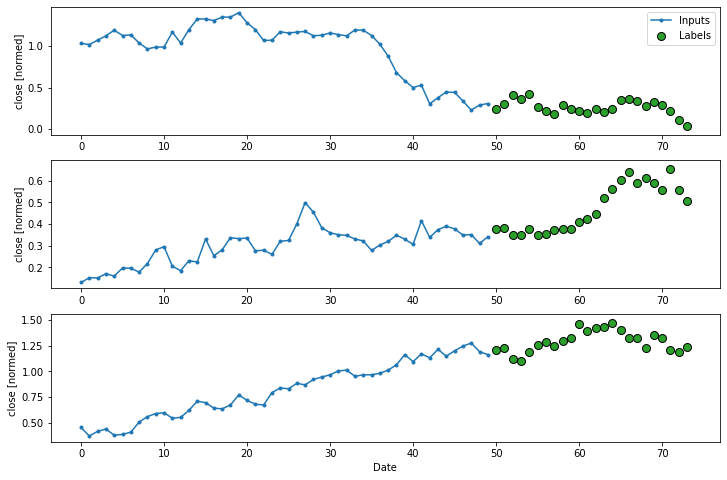

In [13]:

w.plot()

In [14]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

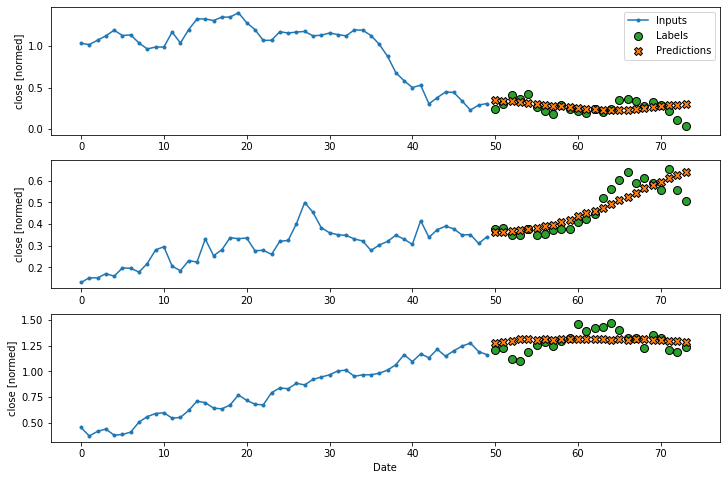

In [15]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(out_points*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([out_points, num_features])
])

history = compile_and_fit(multi_lstm_model, w)

IPython.display.clear_output()

w.plot(multi_lstm_model)

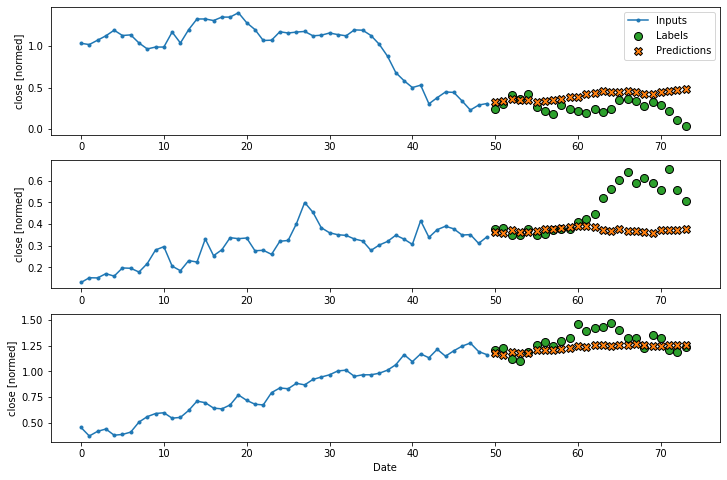

In [16]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(out_points*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([out_points, num_features])
])

history = compile_and_fit(multi_conv_model, w)

IPython.display.clear_output()

w.plot(multi_conv_model)

In [17]:
for example_inputs, example_labels in train.take(1):
    print(f'Window shape: {w.total_window_size}')
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

NameError: name 'train' is not defined

In [19]:
def rsi(df, periods=14, ema=True):
    """
    Retruns Relative strengh index value
    """
    close_delta = df["close"].diff(1).dropna()
    # make 2 series - up and down
    up = close_delta.clip(lower=0)
    down = -1*close_delta.clip(upper=0)
    if ema == True:
        ma_up = up.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
        ma_down = down.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    else:
        #use simple moving avg
        ma_up = up.rolling(window=periods).mean()
        ma_down = down.rolling(window=periods).mean()
        
    rsi = ma_up/ma_down
    rsi = 100 - (100/(1+rsi))
    
    return rsi

def EMA(df, period=20, column="close"):
    return df[column].ewm(span=period, adjust=False).mean()

def MACD(df, period_long=26, period_short=12, period_signal=9, column="close"):
    short_ema = EMA(df, period_short, column=column)   
    long_ema = EMA(df, period_long, column=column)
    df["MACD"] = short_ema-long_ema
    df["SIGNAL_Line"] = EMA(df, period_signal, column="MACD")
    return df

def profits(df, column_open="open", column_close="close"):
    df["profit"] = df[column_close]-df[column_open]
    df["% profit"] = df["profit"]*100/df[column_open]
    return df
 
def ATR(df, look_back=14 ,min_column="MIN", max_column="MAX", close_column="close"):
    high_low = df[max_column] - df[min_column]
    high_close = np.abs(df[max_column] - df[close_column].shift())
    low_close = np.abs(df[min_column] - df[close_column].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df["ATR"] = true_range.rolling(look_back).sum()/look_back
    return df


def get_adx(df, look_back, min_column="MIN", max_column="MAX", close_column="close"):
    plus = df[max_column].diff().clip(lower=0)
    minus = df[min_column].diff().clip(upper=0)
    tr1 = pd.DataFrame(df[max_column]-df[min_column])
    tr2 = pd.DataFrame(abs(df[max_column]-df[close_column].shift(1)))
    tr3 = pd.DataFrame(abs(df[min_column]-df[close_column].shift(1)))
    frames=[tr1, tr2, tr3]
    join_tr = pd.concat(frames, axis=1, join="inner").max(axis=1)
    atr = join_tr.rolling(look_back).mean()
    
    plus_di = 100*(plus.ewm(alpha=1/look_back).mean()/atr)
    minus_di = abs(100*(minus.ewm(alpha=1/look_back).mean()/atr))
    dx = (abs(plus_di-minus_di)/abs(plus_di+minus_di))*100
    adx=((dx.shift(1)*(look_back-1))+dx)/look_back
    adx_smooth = adx.ewm(alpha=1/look_back).mean()
    
    df["plus_di"], df["minus_di"], df["adx_smooth"] = plus_di, minus_di, adx_smooth
    
    return df

In [20]:
rolling_means = [5,10,20,100,200]
for i in rolling_means:
    df.loc[:, "ma"+str(i)] = df.close.rolling(i).mean()

df.head()


,open,MIN,MAX,close,volume,trade,ma5,ma10,ma20,ma100,ATR,plus_di,minus_di,adx_smooth,profit,% profit,MACD,SIGNAL_Line,rsi,ma200
date,,,,,,,,,,,,,,,,,,,,
2000-06-28 00:00:00,21.3,21.3,21.00,21.10,409181.0,17308356.0,NaN,NaN,NaN,NaN,0.400000,22.812376,38.453767,18.928901,-0.20,-0.938967,-0.078375,-0.033901,43.290099,NaN
2000-06-29 00:00:00,21.2,21.6,21.00,21.10,1273651.0,54257533.0,NaN,NaN,NaN,NaN,0.414286,20.451523,34.474187,19.401173,-0.10,-0.471698,-0.108005,-0.048722,43.290099,NaN
2000-06-30 00:00:00,21.0,21.3,20.60,20.69,829135.0,34740757.0,NaN,NaN,NaN,NaN,0.435714,18.055951,35.356877,19.874664,-0.31,-1.476190,-0.162695,-0.071517,38.941619,NaN
2000-07-03 00:00:00,21.0,21.0,20.69,20.80,1008942.0,42062792.0,NaN,NaN,NaN,NaN,0.429286,18.514918,38.315984,20.782431,-0.20,-0.952381,-0.194915,-0.096196,40.663736,NaN
2000-07-04 00:00:00,20.9,20.9,20.69,20.80,1302176.0,54157500.0,20.898,NaN,NaN,NaN,0.415714,17.753027,38.458323,21.798147,-0.10,-0.478469,-0.217937,-0.120544,40.663736,NaN


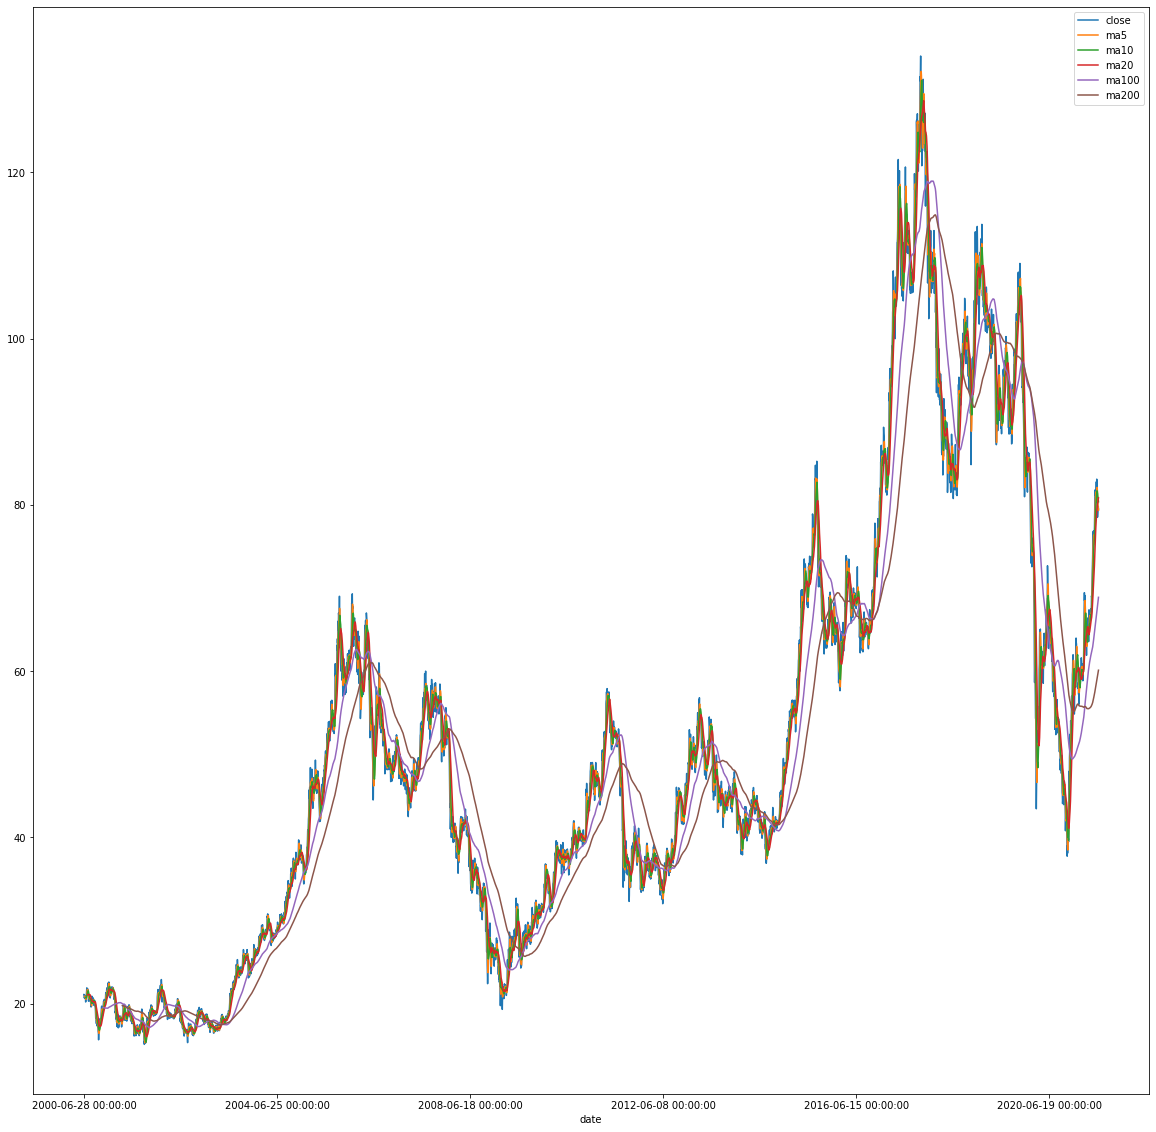

In [21]:
df[["close", "ma5", "ma10", "ma20", "ma100", "ma200"]].plot()

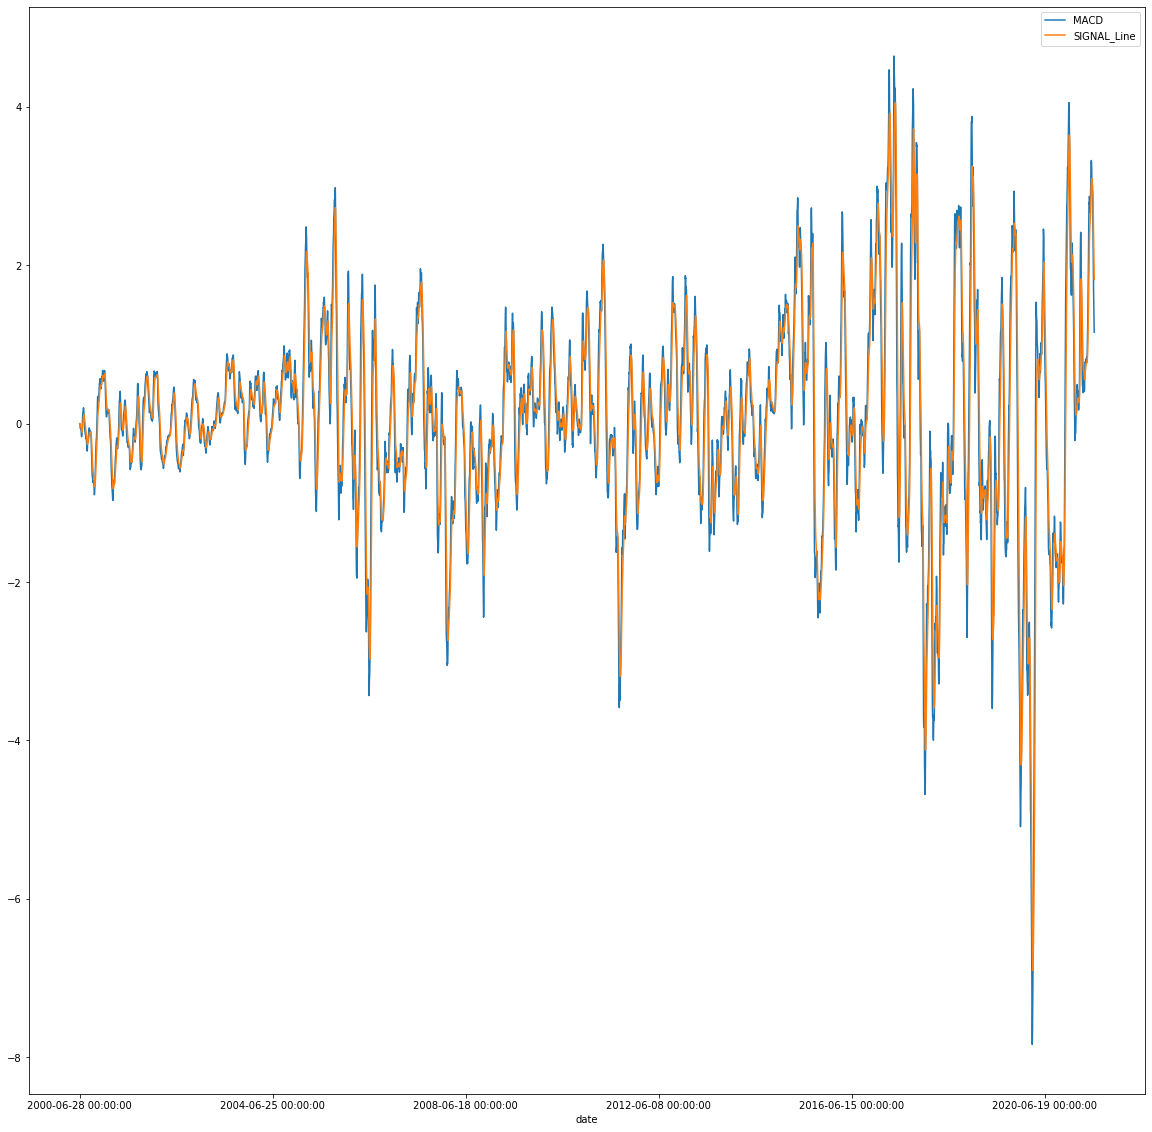

In [22]:
df = MACD(df)
df[["MACD", "SIGNAL_Line"]].plot()

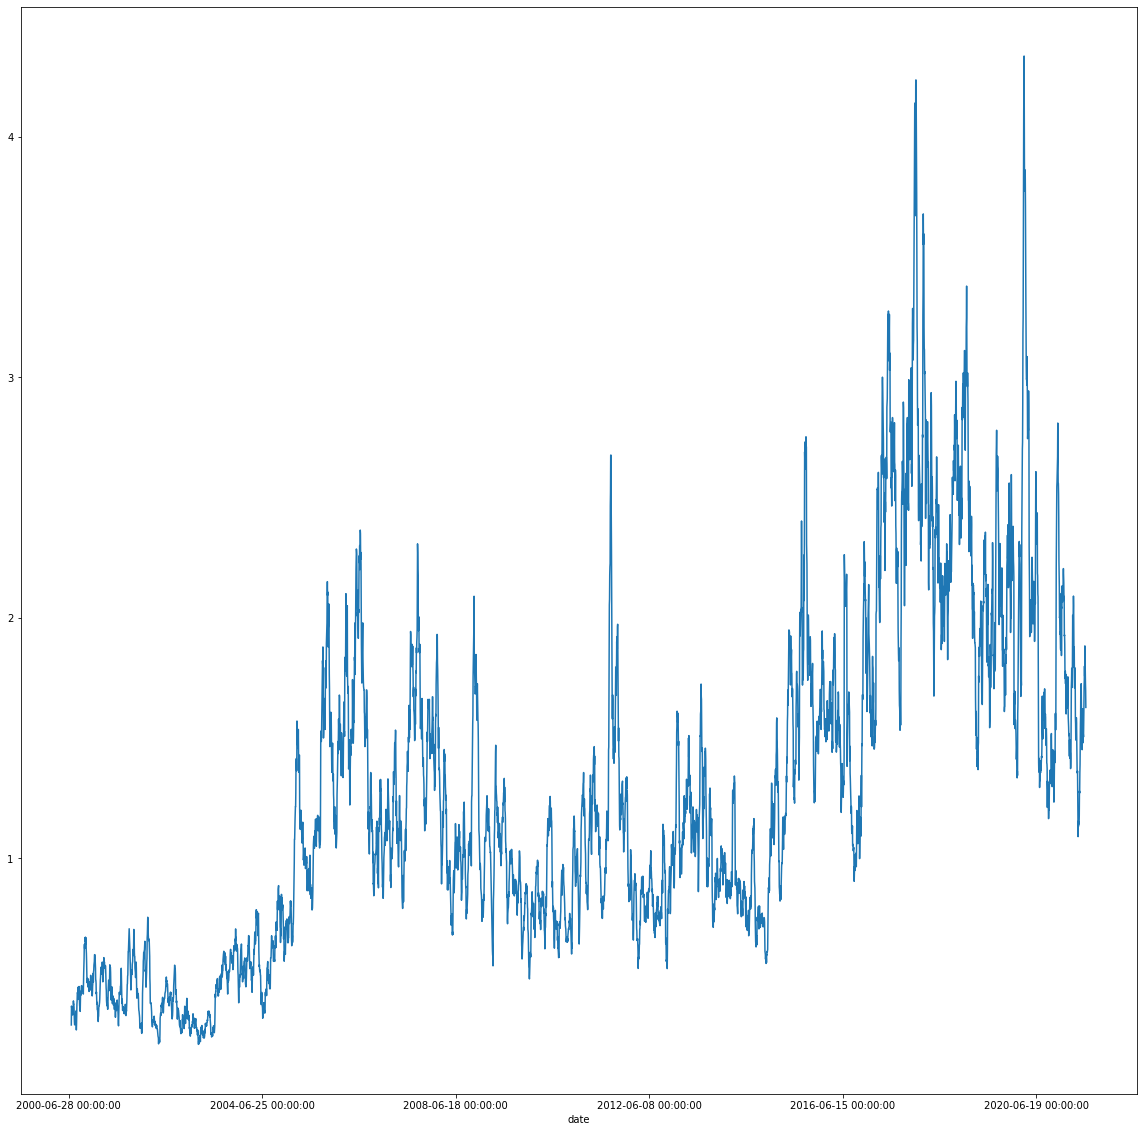

In [23]:
df = ATR(df)
df["ATR"].plot()

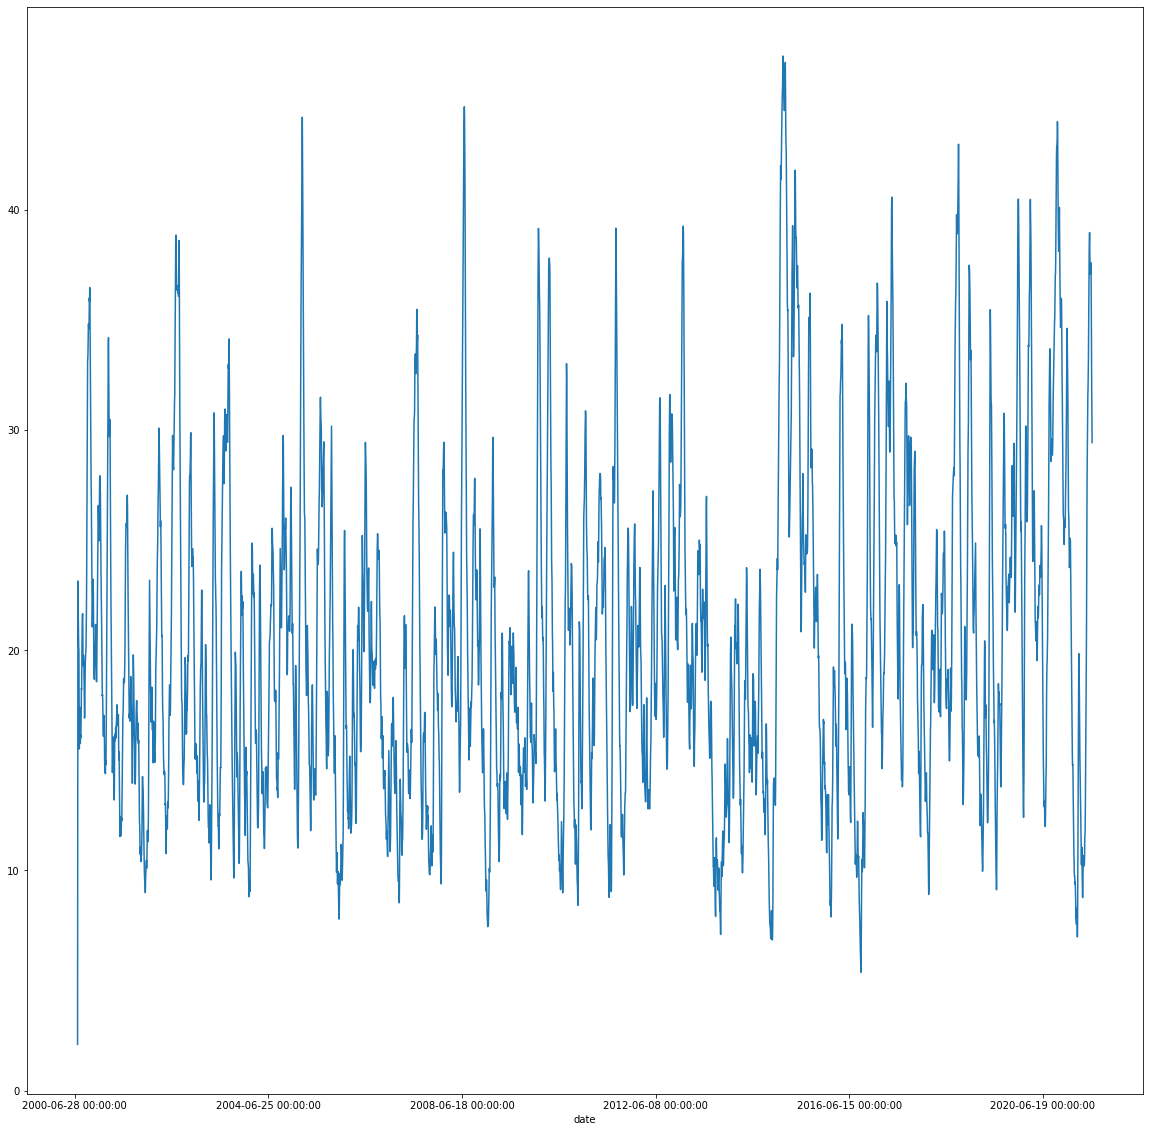

In [24]:
df = get_adx(df, look_back=14)
df["adx_smooth"].plot()

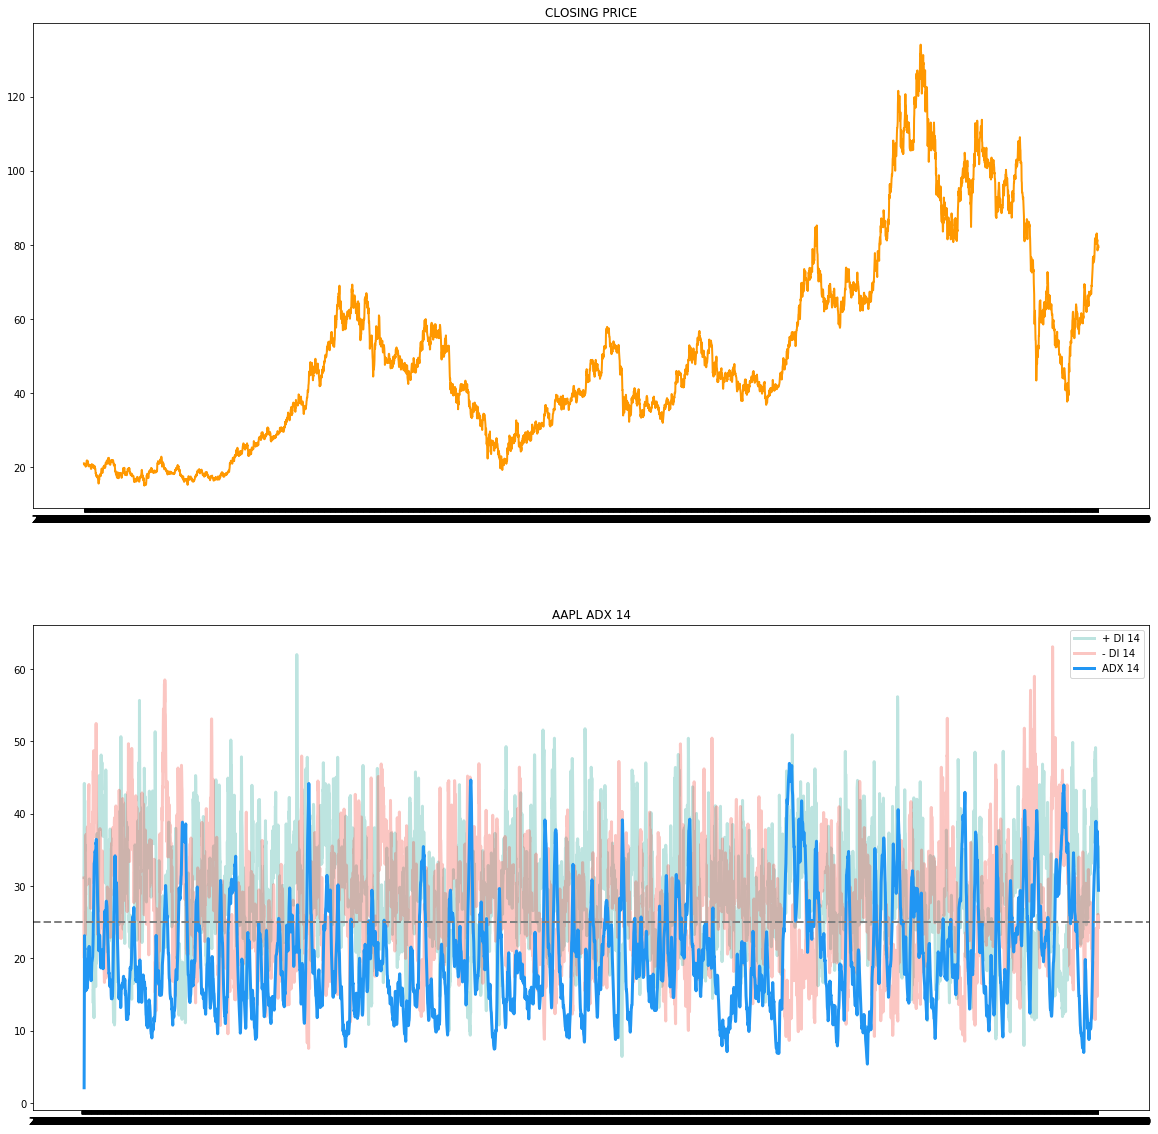

In [25]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(df['close'], linewidth = 2, color = '#ff9800')
ax1.set_title('CLOSING PRICE')
ax2.plot(df['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(df['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(df['adx_smooth'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title('AAPL ADX 14')
plt.show()

In [26]:
df = profits(df)
df.head(50)

,open,MIN,MAX,close,volume,trade,ma5,ma10,ma20,ma100,ATR,plus_di,minus_di,adx_smooth,profit,% profit,MACD,SIGNAL_Line,rsi,ma200
date,,,,,,,,,,,,,,,,,,,,
2000-06-28 00:00:00,21.30,21.30,21.00,21.10,409181.0,17308356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.20,-0.938967,0.000000,0.000000,43.290099,NaN
2000-06-29 00:00:00,21.20,21.60,21.00,21.10,1273651.0,54257533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.10,-0.471698,0.000000,0.000000,43.290099,NaN
2000-06-30 00:00:00,21.00,21.30,20.60,20.69,829135.0,34740757.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.31,-1.476190,-0.032707,-0.006541,38.941619,NaN
2000-07-03 00:00:00,21.00,21.00,20.69,20.80,1008942.0,42062792.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.20,-0.952381,-0.049184,-0.015070,40.663736,NaN
2000-07-04 00:00:00,20.90,20.90,20.69,20.80,1302176.0,54157500.0,20.898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.10,-0.478469,-0.061533,-0.024362,40.663736,NaN
2000-07-05 00:00:00,20.80,21.10,20.80,21.00,1164833.0,48806503.0,20.878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20,0.961538,-0.054552,-0.030400,43.994578,NaN
2000-07-06 00:00:00,20.69,20.80,20.60,20.69,870298.0,36030337.0,20.796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.000000,-0.073191,-0.038958,40.225369,NaN
2000-07-07 00:00:00,20.50,20.80,20.50,20.69,2434909.0,100561742.0,20.796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,0.926829,-0.086959,-0.048559,40.225369,NaN
2000-07-10 00:00:00,20.80,20.80,20.50,20.60,1451396.0,59942655.0,20.756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.20,-0.961538,-0.103935,-0.059634,39.097521,NaN


/home/mateusz/anaconda3/envs/new_env_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  after removing the cwd from sys.path.
/home/mateusz/anaconda3/envs/new_env_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  # This is added back by InteractiveShellApp.init_path()


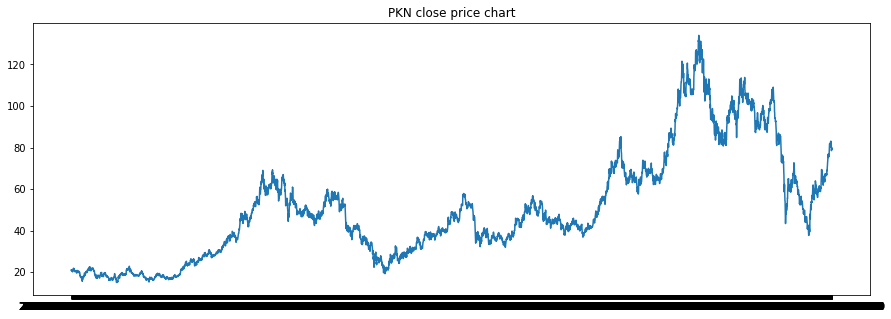

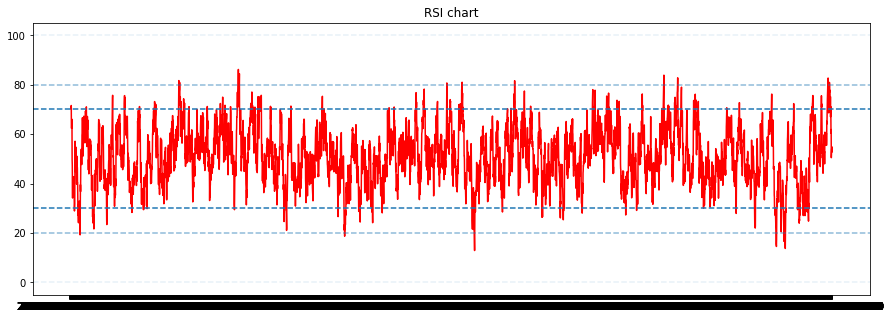

In [27]:
df["rsi"] = rsi(df)
plt.figure(figsize=(15,5))
plt.plot(df.index, df["close"])
plt.locator_params(axis="x", nbins=10)
plt.title("PKN close price chart")

plt.figure(figsize=(15,5))
plt.title("RSI chart")

plt.plot(df.index, df["rsi"], c="r")
plt.locator_params(axis="x", nbins=10)
plt.axhline(0, linestyle="--", alpha=0.1)
plt.axhline(20, linestyle="--", alpha=0.5)
plt.axhline(30, linestyle="--")

plt.axhline(70, linestyle="--")
plt.axhline(80, linestyle="--", alpha=0.5)
plt.axhline(100, linestyle="--", alpha=0.1)

In [28]:
dataset = df.dropna().drop(columns=["open", "MIN", "MAX"])
dataset.head()


,close,volume,trade,ma5,ma10,ma20,ma100,ATR,plus_di,minus_di,adx_smooth,profit,% profit,MACD,SIGNAL_Line,rsi,ma200
date,,,,,,,,,,,,,,,,,
2001-04-10 00:00:00,18.35,614864.0,22381050.0,17.72,17.915,18.0200,19.9973,0.400714,32.378523,32.735091,15.389593,0.45,2.513966,-0.210868,-0.271299,52.209482,19.76870
2001-04-11 00:00:00,18.60,621299.0,23050193.0,18.00,17.935,18.0925,19.9843,0.386429,40.419406,31.520598,14.389767,0.10,0.540541,-0.142583,-0.245556,55.005759,19.75620
2001-04-12 00:00:00,18.70,561705.0,20979682.0,18.28,17.970,18.1200,19.9703,0.372143,38.973084,30.392701,14.245481,0.20,1.081081,-0.079481,-0.212341,56.111949,19.74420
2001-04-17 00:00:00,18.50,313717.0,11513414.0,18.41,17.990,18.1400,19.9523,0.386429,34.851425,35.496406,14.053068,0.35,1.928375,-0.045090,-0.178891,53.290099,19.73325
2001-04-18 00:00:00,19.60,659623.0,25388889.0,18.75,18.150,18.2225,19.9473,0.436429,40.765735,29.184734,13.194557,0.71,3.758602,0.070117,-0.129089,64.010322,19.72725


In [29]:
train_split = int(dataset.shape[0]*0.90)
train_data = dataset[:train_split]
test_data = dataset[train_split:]

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaller_df = MinMaxScaler()
data_to_transform = np.array(train_data).reshape(train_data.shape[0], -1)
test_data_to_transform = np.array(test_data).reshape(test_data.shape[0], -1)
scaller_df = scaller_df.fit(data_to_transform)
df_train = scaller_df.transform(data_to_transform)
df_test = scaller_df.transform(test_data_to_transform)

scaller_close = MinMaxScaler().fit(np.array(train_data['close']).reshape(-1,1))

In [31]:
np.array(train_data['close']).reshape(1,-1).shape

(1, 4551)

In [33]:
index_Close = df.columns.get_loc("close")
sequence_length = 60

def partition_dataset(sequence_length, df, index_close, n_future=1):

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y
    
    return x, y

In [34]:
X, Y = partition_dataset(sequence_length, df_train, index_Close)
X_test, Y_test = partition_dataset(sequence_length, df_test, index_Close)

NameError: name 'data_len' is not defined

In [35]:
X_test.shape

NameError: name 'X_test' is not defined

In [ ]:
import tensorflow as tf
import numpy as np

n_neurons = 50

input_layer = tf.keras.layers.Input(shape=(X.shape[1], X.shape[2]))
lstm1 = tf.keras.layers.LSTM(n_neurons, return_sequences=True)(input_layer)
lstm2 = tf.keras.layers.LSTM(n_neurons, return_sequences=False)(lstm1)
dense1 = tf.keras.layers.Dense(50)(lstm2)
out = tf.keras.layers.Dense(1)(dense1)

#
model = tf.keras.models.Model(input_layer, out)
#
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mse')
epochs = 50
batch_size = 16
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(X, Y, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test)
                   )

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

y_pred_scaled = model.predict(X_test)

# Unscale the predicted values
y_pred = scaller_close.inverse_transform(y_pred_scaled)
y_test_unscaled = scaller_close.inverse_transform(Y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

In [ ]:

points = np.arange(0,y_pred.shape[0],1)
                    
plt.plot(points, y_pred.ravel(), c="#039dfc", linewidth=2.0, label="Prediction")
plt.plot(points, y_test_unscaled.ravel(), c="#E91D9E", linewidth=2.0, label="True")
plt.legend("Pred vs True")
plt.show()                

In [ ]:
df_temp = dataset[-sequence_length:]
new_df = df_temp

from datetime import date, timedelta, datetime
today = date.today()


N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaller_df.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaller_close.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for PKN at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

In [ ]:
y_pred.ravel().shape

In [ ]:
points

In [ ]:
def partition_dataset(sequence_length, df, index_close, n_future=5):
    x, y = [], []
    data_len = df.shape[0]

    for i in range(df.shape[0]-sequence_length-n_future+1):
        y.append(df[(i+n_future-1):(i+n_future), index_close]) #contains sequence_length values 0-sequence_length * columsn
        x.append(df[(i-sequence_length):i, :]) #contains the prediction values for validation,  for single-step prediction

        # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

s, t = partition_dataset(sequence_length, df_train, index_Close)


In [ ]:
t[0]

In [ ]:
df_train[58:65]

In [ ]:
s[1][sequence_length-1][index_Close]


In [ ]:
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])